In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Feature engineering
In this Notebook ill use some clustering, transformations, etc. to try and add some features.

In [4]:
data = pd.read_csv('heart.csv')

In [5]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


#### Train - Test split
Here i'll divide the data set into train and test samples.\
The idea is using feature engineering on the training set, creating a separate module with all the transformations i'll use and then apply all those transformations to the test set. 

In [6]:
X = data.loc[:, data.columns != "target"]
y = data.target

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

##### Here i used a gaussean naive bayes to have a baseline without doing anything

In [11]:
from sklearn.naive_bayes import GaussianNB
baseline = GaussianNB()
baseline.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
print('Baseline : ', accuracy_score(y_test, baseline.predict(X_test)))

Baseline :  0.84


#### Clustering
First i'll see how many clusters would be good with k-means

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

Text(0.5, 1.0, 'sq distances with clusters values')

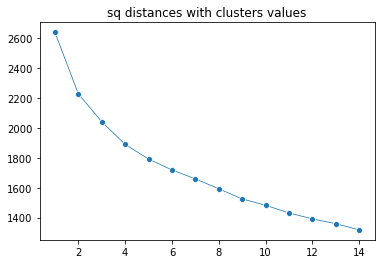

In [21]:
from sklearn.cluster import KMeans
sq_distances = []
k_values = list(range(1,15))


for k in k_values:
    kmeans = KMeans(n_clusters=k,n_init = 100,random_state=0)
    kmeans.fit(X_train_std)
    sq_distances.append(kmeans.inertia_)   
sns.lineplot(x = k_values,y = sq_distances, marker = "o",legend = False,size = 30 ).set_title('sq distances with clusters values') 

Text(0.5, 1.0, 'silhouette score with each cluster')

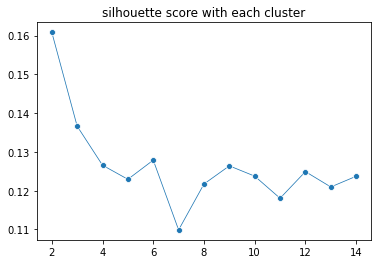

In [22]:
from sklearn.metrics import silhouette_score

silhouette = []
k_values = list(range(2,15))


for k in k_values:
    kmeans = KMeans(n_clusters=k,n_init = 100,random_state=0)
    kmeans.fit(X_train_std)
    score = silhouette_score(X_train_std,kmeans.labels_)
    silhouette.append(score)   
sns.lineplot(x = k_values,y = silhouette, marker = "o",legend = False,size = 30 ).set_title("silhouette score with each cluster") 

Text(0.5, 1.0, 'calinski harabasz score with each cluster')

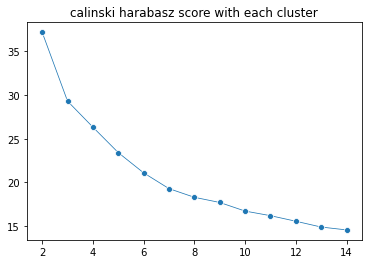

In [23]:
#best K for K-means calinski
from sklearn.metrics import calinski_harabasz_score

calinski_harabaz = []
k_values = list(range(2,15))


for k in k_values:
    kmeans = KMeans(n_clusters=k,n_init = 100,random_state=0)
    kmeans.fit(X_train_std)
    score = calinski_harabasz_score(X_train_std,kmeans.labels_)
    calinski_harabaz.append(score)   
sns.lineplot(x = k_values,y = calinski_harabaz, marker = "o",legend = False,size = 30 ).set_title ("calinski harabasz score with each cluster") 

#### Hierarchical clustering

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage , cophenet , fcluster 
from scipy.spatial.distance import pdist

In [25]:
Z = linkage (X_train_std,"ward")

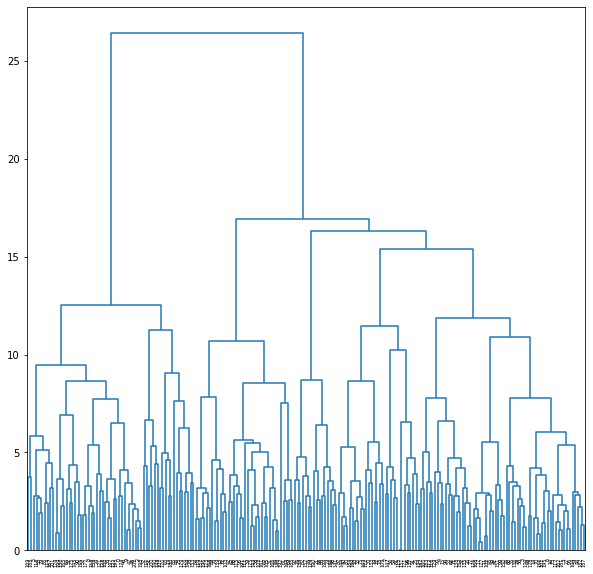

In [27]:
plt.figure(figsize =[10,10])
dendrogram(Z,leaf_rotation = 90, leaf_font_size = 5, color_threshold = 0)
plt.show()

I'ts not clear how many clusters i should use. 2 and 3 clusters have high scores in k-means. I'll use 3 clusters.\
After training the final k-means model i'll add the clusters as a new feature.

In [28]:
kmeans_final = KMeans(n_clusters=3,n_init = 100)

In [29]:
kmeans_final.fit(X_train_std)

KMeans(n_clusters=3, n_init=100)

In [30]:
kmeans_final.labels_

array([1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 1,
       2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 0, 1, 0, 1,
       2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 0, 2,
       1, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 1, 2, 1,
       1, 0, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 1, 2, 2, 2,
       0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 0, 0,
       2, 1, 2, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1,
       2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 0, 2, 0, 1,
       1, 1, 0, 2, 1])

In [31]:
X_train["cluster"] = kmeans_final.labels_

In [32]:
X_train.cluster.value_counts()

2    87
1    66
0    50
Name: cluster, dtype: int64

In [34]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cluster
211,61,1,0,120,260,0,1,140,1,3.6,1,1,3,1
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,2
256,58,1,0,128,259,0,0,130,1,3.0,1,2,3,1
32,44,1,1,130,219,0,0,188,0,0.0,2,0,2,2
13,64,1,3,110,211,0,0,144,1,1.8,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3,1
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3,1
23,61,1,2,150,243,1,1,137,1,1.0,1,0,2,0
73,51,1,0,140,261,0,0,186,1,0.0,2,0,2,2


##### Add interval
Here i add intervals with the thalach feature.

In [35]:
interval_range = pd.interval_range(start=70.0, freq=20, end=210)
X_train['thalach_Intervals'] = pd.cut(data.thalach, bins = interval_range ,duplicates='raise')

In [36]:
X_train

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cluster,thalach_Intervals
211,61,1,0,120,260,0,1,140,1,3.6,1,1,3,1,"(130.0, 150.0]"
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,2,"(170.0, 190.0]"
256,58,1,0,128,259,0,0,130,1,3.0,1,2,3,1,"(110.0, 130.0]"
32,44,1,1,130,219,0,0,188,0,0.0,2,0,2,2,"(170.0, 190.0]"
13,64,1,3,110,211,0,0,144,1,1.8,1,0,2,0,"(130.0, 150.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3,1,"(130.0, 150.0]"
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3,1,"(110.0, 130.0]"
23,61,1,2,150,243,1,1,137,1,1.0,1,0,2,0,"(130.0, 150.0]"
73,51,1,0,140,261,0,0,186,1,0.0,2,0,2,2,"(170.0, 190.0]"


Here i export the k-means model i used to add clusters as a new feature. I also export the scaler i used for the k-means model

In [37]:
import pickle
with open('model_scaler.pkl', 'wb') as f_model_scaler:
    pickle.dump(scaler,  f_model_scaler)
with open('model_kmeans.pkl', 'wb') as f_model_kmeans:
    pickle.dump(kmeans_final,  f_model_kmeans)


Apply some log transformations to trestbps and chol

In [41]:
X_train['log+1_trestbps'] = (X_train['trestbps'] + 1 ).transform(np.log)

In [42]:
X_train['log+1_chol'] = (X_train['chol'] + 1 ).transform(np.log)

In [43]:
X_train.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cluster,thalach_Intervals,log+1_trestbps,log+1_chol
211,61,1,0,120,260,0,1,140,1,3.6,1,1,3,1,"(130.0, 150.0]",4.795791,5.564520
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,2,"(170.0, 190.0]",4.795791,5.062595
256,58,1,0,128,259,0,0,130,1,3.0,1,2,3,1,"(110.0, 130.0]",4.859812,5.560682


##### Onehotencoder
Use a onehotencoder for the thalach Intervals i created earlier.\
Then export the trained onehotencoder for using in the data processing module.

In [44]:
from sklearn.preprocessing import OneHotEncoder 
onehot_encoder = OneHotEncoder(drop='first')

In [45]:
dummy_oneHot = onehot_encoder.fit_transform(X_train[['thalach_Intervals']])

In [46]:
dummy_oneHot = pd.DataFrame(dummy_oneHot.toarray())
dummy_oneHot.head()

,0,1,2,3,4,5
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


In [47]:
with open('model_ohe.pkl', 'wb') as f_model_ohe:
    pickle.dump(onehot_encoder,  f_model_ohe)

##### Export datasets
Finally i renamed some columns and exported the train and test data sets. The features and the target are also in different data sets, so it's 4 data sets in total.

In [48]:
dummy_oneHot.rename(columns = {0:'thalach_Intervals_(90.0, 110.0]',1:'halach_Intervals_(110.0, 130.0]',2:'thalach_Intervals_(130.0, 150.0]',3:'thalach_Intervals_(150.0, 170.0]',4:'thalach_Intervals_(170.0, 190.0]',5:'thalach_Intervals_(190.0, 210.0]'},inplace = True)

In [49]:
X_train = pd.merge(X_train, dummy_oneHot , on= X_train.index)
X_train.drop(inplace = True,columns =['thalach_Intervals'])

In [50]:
X_train

,key_0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,...,thal,cluster,log+1_trestbps,log+1_chol,"thalach_Intervals_(90.0, 110.0]","halach_Intervals_(110.0, 130.0]","thalach_Intervals_(130.0, 150.0]","thalach_Intervals_(150.0, 170.0]","thalach_Intervals_(170.0, 190.0]","thalach_Intervals_(190.0, 210.0]"
0,211,61,1,0,120,260,0,1,140,1,...,3,1,4.795791,5.564520,0.0,0.0,1.0,0.0,0.0,0.0
1,162,41,1,1,120,157,0,1,182,0,...,2,2,4.795791,5.062595,0.0,0.0,0.0,0.0,1.0,0.0
2,256,58,1,0,128,259,0,0,130,1,...,3,1,4.859812,5.560682,0.0,1.0,0.0,0.0,0.0,0.0
3,32,44,1,1,130,219,0,0,188,0,...,2,2,4.875197,5.393628,0.0,0.0,0.0,0.0,1.0,0.0
4,13,64,1,3,110,211,0,0,144,1,...,2,0,4.709530,5.356586,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,201,60,1,0,125,258,0,0,141,1,...,3,1,4.836282,5.556828,0.0,0.0,1.0,0.0,0.0,0.0
199,178,43,1,0,120,177,0,0,120,1,...,3,1,4.795791,5.181784,0.0,1.0,0.0,0.0,0.0,0.0
200,23,61,1,2,150,243,1,1,137,1,...,2,0,5.017280,5.497168,0.0,0.0,1.0,0.0,0.0,0.0
201,73,51,1,0,140,261,0,0,186,1,...,2,2,4.948760,5.568345,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
y_train

211    0
162    1
256    0
32     1
13     1
      ..
201    0
178    0
23     1
73     1
193    0
Name: target, Length: 203, dtype: int64

In [52]:
X_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
20,59,1,0,135,234,0,1,161,0,0.5,1,0,3
42,45,1,0,104,208,0,0,148,1,3.0,1,0,2
206,59,1,0,110,239,0,0,142,1,1.2,1,1,3
52,62,1,2,130,231,0,1,146,0,1.8,1,3,3
166,67,1,0,120,229,0,0,129,1,2.6,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3
64,58,1,2,140,211,1,0,165,0,0.0,2,0,2
165,67,1,0,160,286,0,0,108,1,1.5,1,3,2
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2


In [53]:
y_test

20     1
42     1
206    0
52     1
166    0
      ..
7      1
64     1
165    0
80     1
108    1
Name: target, Length: 100, dtype: int64

In [54]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')